In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

pd.set_option('display.max_rows', 500)

In [2]:
#aggregated_data = pd.read_csv('../data/aggregated_data_selection.csv')
# atm_data = aggregated_data[aggregated_data['demanda_shifted'] != 0]
# aggregated_data = pd.read_csv('../data/aggregated_data_extra_metrics.csv')
aggregated_data = pd.read_csv('../data/aggregated_data_extra_metrics.csv')
aggregated_data.head()

,fecha_transaccion,codigo_cajero,tipo_cajero,saldo_inicial,demanda,abastecimiento,saldo_final,Type,Weekday,Holiday Sequence,...,isWeekday,isPaymentDay,isPayweek,rolling_mean_weekday,rolling_max,lag_6,lag_7,rolling_max_weekday,rolling_std,rolling_mean
0,2023-06-02,6,B,644690.0,243020.0,0.0,401670.0,No Holiday,FRIDAY,WHH,...,True,False,True,243020.0,364110.0,243020.0,243020.0,243020.0,182237.310761,160781.724138
1,2023-06-02,32,B,775480.0,265420.0,0.0,510060.0,No Holiday,FRIDAY,WHH,...,True,False,True,265420.0,476500.0,265420.0,265420.0,265420.0,158371.404405,184831.379310
2,2023-06-02,116,B,668240.0,244340.0,0.0,423900.0,No Holiday,FRIDAY,WHH,...,True,False,True,244340.0,244340.0,244340.0,244340.0,244340.0,22634.380928,182509.655172
3,2023-06-02,525,A,30110.0,8250.0,226470.0,248330.0,No Holiday,FRIDAY,WHH,...,True,False,True,8250.0,206430.0,8250.0,8250.0,8250.0,115841.744347,140405.517241
4,2023-06-02,302,A,70720.0,11760.0,350460.0,409420.0,No Holiday,FRIDAY,WHH,...,True,False,True,11760.0,343400.0,11760.0,11760.0,11760.0,189907.456497,165362.413793


In [3]:
def smape_fun(actual, predicted):
    return 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

# Modelo Final

# RANDOM FOREST REGRESSOR (A 7 DÍAS)

In [80]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [24]:
i = 333
# PARA CAJERO 1
atm_data = aggregated_data[aggregated_data['codigo_cajero'] == i]
#codigo_cajero = i
#tipo_cajero = atm_data['tipo_cajero'].iloc[0]
#resultado_final.append(codigo_cajero)
#resultado_final.append(tipo_cajero)
atm_data = atm_data.sort_values(by=['fecha_transaccion'])
atm_data = atm_data.drop(columns=['codigo_cajero', 'Type'])
categorical_features_list = ['tipo_cajero', 'Weekday', 'Holiday Sequence']
atm_data = pd.get_dummies(atm_data, columns=categorical_features_list, drop_first=True)
# atm_data = atm_data.drop(columns=['Holiday Sequence'])
# categorical_features_list = ['tipo_cajero', 'Weekday', 'Holiday Sequence']
# atm_data = atm_data.drop(columns=['Weekday'])

# categorical_features_list = ['tipo_cajero', 'Holiday Sequence']
# atm_data = atm_data.drop(columns=categorical_features_list, axis=1)
# atm_data = pd.get_dummies(atm_data, columns=categorical_features_list, drop_first=True)


atm_data['demanda_shifted'] = atm_data['demanda'].shift(-7)
atm_data['fecha_transaccion'] = pd.to_datetime(atm_data['fecha_transaccion'])

real_X_test = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2024-05-14"))]
real_X_test = real_X_test.drop(columns=["demanda"], axis=1)

atm_data = atm_data[atm_data['demanda_shifted'].notna()]
atm_data = atm_data.drop(columns=["demanda"], axis=1)


# for obs in range(1,6):
#     atm_data["demanda_shifted_" + str(obs)] = atm_data['demanda_shifted'].shift(obs, fill_value=0)


atm_data['fecha_transaccion'] = pd.to_datetime(atm_data['fecha_transaccion'])
atm_data = atm_data.sort_values(by=['fecha_transaccion'])

_min_date = atm_data['fecha_transaccion'].min()
_max_date = atm_data['fecha_transaccion'].max()

_difference = (_max_date - _min_date).days

# 8:1:1
_end_train = pd.to_datetime(_min_date) + pd.DateOffset(days=int(_difference * 0.7))
_end_val = pd.to_datetime(_max_date) - pd.DateOffset(days=int(_difference * 0.15))


atm_data_train = atm_data.loc[(atm_data['fecha_transaccion'] < pd.to_datetime(_end_train))]

atm_data_val = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime(_end_train)) & \
                                (atm_data['fecha_transaccion'] < pd.to_datetime(_end_val))]
                                
atm_data_test = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime(_end_val))]

clean_atm_train = atm_data_train.drop(columns=["fecha_transaccion"], axis=1)
clean_atm_val = atm_data_val.drop(columns=["fecha_transaccion"], axis=1)
clean_atm_test = atm_data_test.drop(columns=["fecha_transaccion"], axis=1)


X_atm_train, y_atm_train = clean_atm_train.drop(["demanda_shifted"],axis=1), clean_atm_train['demanda_shifted']
X_atm_val, y_atm_val = clean_atm_val.drop(["demanda_shifted"],axis=1), clean_atm_val['demanda_shifted']
X_atm_test, y_atm_test = clean_atm_test.drop(["demanda_shifted"],axis=1), clean_atm_test['demanda_shifted']

# print(X_atm_train.columns)

rfr = RandomForestRegressor(random_state=2024,verbose=0,n_jobs=5, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=200)
# rfr = RandomForestRegressor(random_state=2024,verbose=0,n_jobs=5)
rfr.fit(X_atm_train, y_atm_train)

prediccion_val = rfr.predict(X_atm_val)

y_pred = rfr.predict(X_atm_test)

# Igualando lo que fue realizado igual con el conjutno de datos de training
real_X_test = real_X_test.drop(['fecha_transaccion', 'demanda_shifted'], axis=1)

real_y_pred = rfr.predict(real_X_test)
# print(real_y_pred)

# Calcula el promedio del feature importance de todos los árboles
#feature_importance = rfr.feature_importances_
#mean_feature_importance = np.mean(feature_importance)
#print(f'Mean Feature Importance: {mean_feature_importance:.2f}')

# Igualando lo que fue realizado igual con el conjutno de datos de training
resultado_final.append(real_y_pred)

# Calcular MAPE, MAE, MSE y RMSE
r2 = r2_score(y_atm_test, y_pred)
mape = mean_absolute_percentage_error(y_atm_test, y_pred)
mae = mean_absolute_error(y_atm_test, y_pred)
mse = mean_squared_error(y_atm_test, y_pred)
rmse = np.sqrt(mse)
smape = smape_fun(y_atm_test, y_pred)


# print(y_pred)
# Mostrar los resultados
print(f'ATM {i:3d} => TEST => R2: {r2:.2f} SMAPE: {smape:.2f}% MAPE: {mape:.2f}% MAE: {mae:.2f} MSE: {mse:.2f} RMSE: {rmse:.2f}')


#if(i % 20 == 0):
#    break


ATM 333 => TEST => R2: 0.89 SMAPE: 35.28% MAPE: 0.54% MAE: 36136.55 MSE: 3261386242.61 RMSE: 57108.55


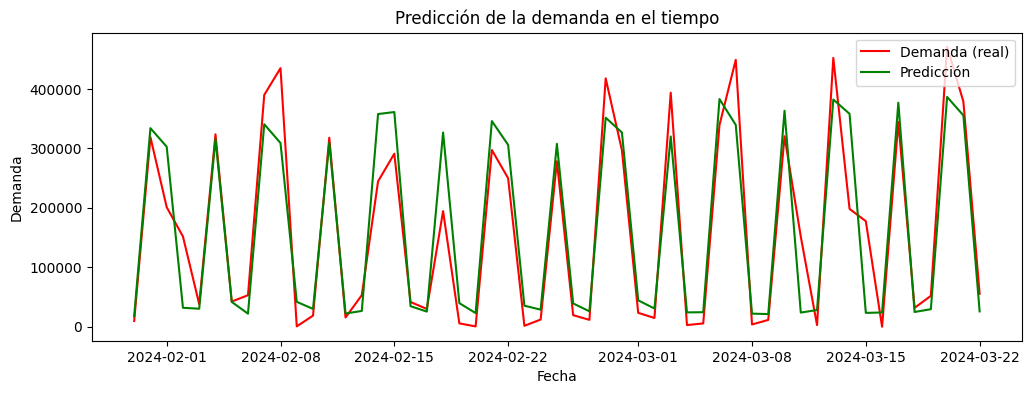

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Genera arrays de tiempo y valores para las dos líneas
# t = np.linspace(0, 10, 242)  # Tiempo desde 0 a 10 segundos con 100 puntos
t = atm_data_val['fecha_transaccion']  # Tiempo desde 0 a 10 segundos con 100 puntos

y1 = y_atm_val
y2 = prediccion_val

# Crea la figura y el eje
plt.figure(figsize=(12,4))
ax = plt.subplot(111)

# Plotea las dos líneas de tiempo
ax.plot(t, y1, label='Demanda (real)', color='red')
ax.plot(t, y2, label='Predicción', color='green')

# Personaliza la gráfica
ax.set_title('Predicción de la demanda en el tiempo')
ax.set_xlabel('Fecha')
ax.set_ylabel('Demanda')
ax.legend(loc='upper right')  # Localiza la leyenda en la esquina superior derecha

# Muestra la gráfica
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

resultado_final = []
codigo_cajero = 0
def la_bandide():
    for i in range(1, 700 + 1):
        # PARA CAJERO 1
        atm_data = aggregated_data[aggregated_data['codigo_cajero'] == i]
        #codigo_cajero = i
        #tipo_cajero = atm_data['tipo_cajero'].iloc[0]
        #resultado_final.append(codigo_cajero)
        #resultado_final.append(tipo_cajero)
        atm_data = atm_data.sort_values(by=['fecha_transaccion'])
        atm_data = atm_data.drop(columns=['codigo_cajero', 'Type'])
        categorical_features_list = ['tipo_cajero', 'Weekday', 'Holiday Sequence']
        atm_data = pd.get_dummies(atm_data, columns=categorical_features_list, drop_first=True)
        # atm_data = atm_data.drop(columns=['Holiday Sequence'])
        # categorical_features_list = ['tipo_cajero', 'Weekday', 'Holiday Sequence']
        # atm_data = atm_data.drop(columns=['Weekday'])

        # categorical_features_list = ['tipo_cajero', 'Holiday Sequence']
        # atm_data = atm_data.drop(columns=categorical_features_list, axis=1)
        # atm_data = pd.get_dummies(atm_data, columns=categorical_features_list, drop_first=True)


        atm_data['demanda_shifted'] = atm_data['demanda'].shift(-7)
        atm_data['fecha_transaccion'] = pd.to_datetime(atm_data['fecha_transaccion'])

        real_X_test = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2024-05-14"))]
        real_X_test = real_X_test.drop(columns=["demanda"], axis=1)

        atm_data = atm_data[atm_data['demanda_shifted'].notna()]
        atm_data = atm_data.drop(columns=["demanda"], axis=1)


        # for obs in range(1,6):
        #     atm_data["demanda_shifted_" + str(obs)] = atm_data['demanda_shifted'].shift(obs, fill_value=0)


        atm_data['fecha_transaccion'] = pd.to_datetime(atm_data['fecha_transaccion'])
        atm_data = atm_data.sort_values(by=['fecha_transaccion'])

        _min_date = atm_data['fecha_transaccion'].min()
        _max_date = atm_data['fecha_transaccion'].max()

        _difference = (_max_date - _min_date).days

        # 8:1:1
        _end_train = pd.to_datetime(_min_date) + pd.DateOffset(days=int(_difference * 0.7))
        _end_val = pd.to_datetime(_max_date) - pd.DateOffset(days=int(_difference * 0.15))


        atm_data_train = atm_data.loc[(atm_data['fecha_transaccion'] < pd.to_datetime(_end_train))]

        atm_data_val = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime(_end_train)) & \
                                        (atm_data['fecha_transaccion'] < pd.to_datetime(_end_val))]
                                        
        atm_data_test = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime(_end_val))]

        clean_atm_train = atm_data_train.drop(columns=["fecha_transaccion"], axis=1)
        clean_atm_val = atm_data_val.drop(columns=["fecha_transaccion"], axis=1)
        clean_atm_test = atm_data_test.drop(columns=["fecha_transaccion"], axis=1)


        X_atm_train, y_atm_train = clean_atm_train.drop(["demanda_shifted"],axis=1), clean_atm_train['demanda_shifted']
        X_atm_val, y_atm_val = clean_atm_val.drop(["demanda_shifted"],axis=1), clean_atm_val['demanda_shifted']
        X_atm_test, y_atm_test = clean_atm_test.drop(["demanda_shifted"],axis=1), clean_atm_test['demanda_shifted']

        # print(X_atm_train.columns)

        rfr = RandomForestRegressor(random_state=2024,verbose=0,n_jobs=5, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=200)
        # rfr = RandomForestRegressor(random_state=2024,verbose=0,n_jobs=5)
        rfr.fit(X_atm_train, y_atm_train)

        y_pred = rfr.predict(X_atm_test)

        # Igualando lo que fue realizado igual con el conjutno de datos de training
        real_X_test = real_X_test.drop(['fecha_transaccion', 'demanda_shifted'], axis=1)

        real_y_pred = rfr.predict(real_X_test)
        # print(real_y_pred)

        # Calcula el promedio del feature importance de todos los árboles
        #feature_importance = rfr.feature_importances_
        #mean_feature_importance = np.mean(feature_importance)
        #print(f'Mean Feature Importance: {mean_feature_importance:.2f}')

        # Igualando lo que fue realizado igual con el conjutno de datos de training
        resultado_final.append(real_y_pred)

        # Calcular MAPE, MAE, MSE y RMSE
        r2 = r2_score(y_atm_test, y_pred)
        mape = mean_absolute_percentage_error(y_atm_test, y_pred)
        mae = mean_absolute_error(y_atm_test, y_pred)
        mse = mean_squared_error(y_atm_test, y_pred)
        rmse = np.sqrt(mse)
        smape = smape_fun(y_atm_test, y_pred)


        # print(y_pred)
        # Mostrar los resultados
        print(f'ATM {i:3d} => TEST => R2: {r2:.2f} SMAPE: {smape:.2f}% MAPE: {mape:.2f}% MAE: {mae:.2f} MSE: {mse:.2f} RMSE: {rmse:.2f}')


        # if(i % 100 == 0):
        #    break

la_bandide()

redondeados = [[int(i) for i in x] for x in resultado_final]
#print(redondeados)
# Salida: [[3.14, 2.72], [1.62, 0.58]]

# # Crea un DataFrame a partir de la lista de listas y exportar
final_final = pd.DataFrame(redondeados)

#print(redondeados)
final_final.columns = ['demanda_20240521', 'demanda_20240522', 'demanda_20240523', 'demanda_20240524', 'demanda_20240525', 'demanda_20240526', 'demanda_20240527']
final_final.to_csv('../data/resultado_final.csv', index=False)

ATM   1 => TEST => R2: 0.81 SMAPE: 47.50% MAPE: 1.06% MAE: 48442.22 MSE: 4838310478.27 RMSE: 69557.96
ATM   2 => TEST => R2: 0.85 SMAPE: 52.02% MAPE: 1.53% MAE: 39383.18 MSE: 3822563509.63 RMSE: 61826.88
ATM   3 => TEST => R2: 0.84 SMAPE: 50.68% MAPE: 2.47% MAE: 40259.03 MSE: 4223925419.22 RMSE: 64991.73
ATM   4 => TEST => R2: 0.70 SMAPE: 58.20% MAPE: 1.11% MAE: 63185.58 MSE: 7488565487.78 RMSE: 86536.50
ATM   5 => TEST => R2: 0.84 SMAPE: 52.60% MAPE: 2.08% MAE: 43032.52 MSE: 4238054884.74 RMSE: 65100.34
ATM   6 => TEST => R2: 0.82 SMAPE: 51.57% MAPE: 1.45% MAE: 53435.18 MSE: 5955260319.88 RMSE: 77170.33
ATM   7 => TEST => R2: 0.67 SMAPE: 79.43% MAPE: 3.28% MAE: 67761.03 MSE: 8434375191.24 RMSE: 91838.85
ATM   8 => TEST => R2: 0.86 SMAPE: 49.47% MAPE: 1.71% MAE: 44739.60 MSE: 4247722799.13 RMSE: 65174.56
ATM   9 => TEST => R2: 0.77 SMAPE: 61.86% MAPE: 3.62% MAE: 51143.78 MSE: 6573205961.52 RMSE: 81075.31
ATM  10 => TEST => R2: 0.87 SMAPE: 52.25% MAPE: 5.06% MAE: 40523.64 MSE: 320941294

KeyboardInterrupt: 

In [13]:
atm_1 = aggregated_data[aggregated_data['codigo_cajero'] == 1]
atm_1.head(2)

,fecha_transaccion,codigo_cajero,tipo_cajero,saldo_inicial,demanda,abastecimiento,saldo_final,Type,Weekday,Holiday Sequence,...,isTomorrowWeekday,isWeekday,isPaymentDay,isPayweek,rolling_mean_weekday,rolling_max,lag_6,rolling_max_weekday,rolling_std,rolling_mean
55650,2023-06-02,1,B,647830,384630,0,263200,No Holiday,FRIDAY,WHH,...,False,True,False,True,384630.0,384630,384630.0,384630.0,224333.783085,167457.241379
55651,2023-06-03,1,B,263200,251860,0,11340,No Holiday,SATURDAY,WWW,...,False,False,False,True,251860.0,384630,251860.0,251860.0,224333.783085,167457.241379


In [14]:
fig = px.line(atm_1, x='fecha_transaccion', y='demanda', 
                      labels={'x':'Test Row Number', 'y':'Residual Error'}, title='Residual Error Plot')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [15]:
atm_1 = atm_1.drop(columns=['codigo_cajero', 'Type'])
atm_1.columns

Index(['fecha_transaccion', 'tipo_cajero', 'saldo_inicial', 'demanda',
       'abastecimiento', 'saldo_final', 'Weekday', 'Holiday Sequence',
       'isYesterdayHoliday', 'isHoliday', 'isTomorrowHoliday',
       'isYesterdayWeekday', 'isTomorrowWeekday', 'isWeekday', 'isPaymentDay',
       'isPayweek', 'rolling_mean_weekday', 'rolling_max', 'lag_6',
       'rolling_max_weekday', 'rolling_std', 'rolling_mean'],
      dtype='object')

In [16]:
categorical_features_list = ['tipo_cajero', 'Weekday', 'Holiday Sequence']
atm_1 = pd.get_dummies(atm_1, columns=categorical_features_list, drop_first=True)

In [17]:
atm_1.head()

,fecha_transaccion,saldo_inicial,demanda,abastecimiento,saldo_final,isYesterdayHoliday,isHoliday,isTomorrowHoliday,isYesterdayWeekday,isTomorrowWeekday,...,Weekday_THURSDAY,Weekday_TUESDAY,Weekday_WEDNESDAY,Holiday Sequence_HHW,Holiday Sequence_HWH,Holiday Sequence_HWW,Holiday Sequence_WHH,Holiday Sequence_WHW,Holiday Sequence_WWH,Holiday Sequence_WWW
55650,2023-06-02,647830,384630,0,263200,False,True,True,True,False,...,False,False,False,False,False,False,True,False,False,False
55651,2023-06-03,263200,251860,0,11340,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
55652,2023-06-04,11340,-52910,0,64250,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
55653,2023-06-05,64250,24710,357330,396870,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
55654,2023-06-06,396870,44010,0,352860,False,False,True,True,True,...,False,True,False,False,False,False,False,False,True,False


In [18]:
for obs in range(1,6):
    atm_1["demanda_" + str(obs)] = atm_1['demanda'].shift(obs, fill_value=0)

atm_1.tail(4)

,fecha_transaccion,saldo_inicial,demanda,abastecimiento,saldo_final,isYesterdayHoliday,isHoliday,isTomorrowHoliday,isYesterdayWeekday,isTomorrowWeekday,...,Holiday Sequence_HWW,Holiday Sequence_WHH,Holiday Sequence_WHW,Holiday Sequence_WWH,Holiday Sequence_WWW,demanda_1,demanda_2,demanda_3,demanda_4,demanda_5
55964,2024-04-11,306520,32530,290250,564240,False,False,False,True,True,...,False,False,False,False,True,234980,22370,2500,-7800,288950
55965,2024-04-12,564240,257970,0,306270,False,False,False,True,False,...,False,False,False,False,True,32530,234980,22370,2500,-7800
55966,2024-04-13,306270,223920,0,82350,False,False,False,True,False,...,False,False,False,False,True,257970,32530,234980,22370,2500
55967,2024-04-14,82350,64740,0,17610,True,True,True,False,True,...,False,False,False,False,False,223920,257970,32530,234980,22370


In [19]:
min_date = atm_1['fecha_transaccion'].min()
max_date = atm_1['fecha_transaccion'].max()
print(min_date)
print(max_date)
print(pd.to_datetime(atm_1['fecha_transaccion'].max()) - pd.to_datetime(atm_1['fecha_transaccion'].min()))
difference = 317
# 8:1:1
# aggregated_data['Transaction Date'] = aggregated_data['Transaction Date'] + pd.DateOffset(years=7)
print(difference * 0.8)
print(difference * 0.1)
print(difference * 0.1)

print(pd.to_datetime(min_date) + pd.DateOffset(days=int(difference * 0.8)))
print(pd.to_datetime(max_date) - pd.DateOffset(days=int(difference * 0.1)))

2023-06-02
2024-04-14
317 days 00:00:00
253.60000000000002
31.700000000000003
31.700000000000003
2024-02-10 00:00:00
2024-03-14 00:00:00


In [20]:
atm_1['fecha_transaccion'] = pd.to_datetime(atm_1['fecha_transaccion'])

In [21]:
atm_1_train = atm_1.loc[(atm_1['fecha_transaccion'] >= pd.to_datetime("2023-06-02")) & \
                                  (atm_1['fecha_transaccion'] < pd.to_datetime("2024-02-10"))]

atm_1_val = atm_1.loc[(atm_1['fecha_transaccion'] >= pd.to_datetime("2024-02-10")) & \
                                (atm_1['fecha_transaccion'] < pd.to_datetime("2024-03-14"))]
                                
atm_1_test = atm_1.loc[(atm_1['fecha_transaccion'] >= pd.to_datetime("2024-03-14")) & \
                                 (atm_1['fecha_transaccion'] < pd.to_datetime("2024-04-14"))]

atm_1_train.tail(2)                                 

,fecha_transaccion,saldo_inicial,demanda,abastecimiento,saldo_final,isYesterdayHoliday,isHoliday,isTomorrowHoliday,isYesterdayWeekday,isTomorrowWeekday,...,Holiday Sequence_HWW,Holiday Sequence_WHH,Holiday Sequence_WHW,Holiday Sequence_WWH,Holiday Sequence_WWW,demanda_1,demanda_2,demanda_3,demanda_4,demanda_5
55901,2024-02-08,276580,19110,312670,570140,False,False,False,True,True,...,False,False,False,False,True,241360,35190,12210,-11230,268180
55902,2024-02-09,570140,233240,0,336900,False,False,False,True,False,...,False,False,False,False,True,19110,241360,35190,12210,-11230


In [34]:
atm_1_train.columns

Index(['fecha_transaccion', 'saldo_inicial', 'demanda', 'abastecimiento',
       'saldo_final', 'isYesterdayHoliday', 'isHoliday', 'isTomorrowHoliday',
       'isYesterdayWeekday', 'isTomorrowWeekday', 'isWeekday', 'isPaymentDay',
       'isPayweek', 'rolling_mean_weekday', 'rolling_max', 'lag_6',
       'rolling_max_weekday', 'rolling_std', 'rolling_mean', 'Weekday_MONDAY',
       'Weekday_SATURDAY', 'Weekday_SUNDAY', 'Weekday_THURSDAY',
       'Weekday_TUESDAY', 'Weekday_WEDNESDAY', 'Holiday Sequence_HHW',
       'Holiday Sequence_HWH', 'Holiday Sequence_HWW', 'Holiday Sequence_WHH',
       'Holiday Sequence_WHW', 'Holiday Sequence_WWH', 'Holiday Sequence_WWW',
       'demanda_1', 'demanda_2', 'demanda_3', 'demanda_4', 'demanda_5'],
      dtype='object')

In [22]:
clean_train = atm_1_train[['saldo_inicial', 'demanda', 'abastecimiento',
       'saldo_final', 'isYesterdayHoliday', 'isHoliday', 'isTomorrowHoliday',
       'isYesterdayWeekday', 'isTomorrowWeekday', 'isWeekday', 'isPaymentDay',
       'isPayweek', 'rolling_mean_weekday', 'rolling_max', 'lag_6',
       'rolling_max_weekday', 'rolling_std', 'rolling_mean', 'Weekday_MONDAY',
       'Weekday_SATURDAY', 'Weekday_SUNDAY', 'Weekday_THURSDAY',
       'Weekday_TUESDAY', 'Weekday_WEDNESDAY', 'Holiday Sequence_HHW',
       'Holiday Sequence_HWH', 'Holiday Sequence_HWW', 'Holiday Sequence_WHH',
       'Holiday Sequence_WHW', 'Holiday Sequence_WWH', 'Holiday Sequence_WWW',
       'demanda_1', 'demanda_2', 'demanda_3', 'demanda_4', 'demanda_5']]
clean_val = atm_1_val[['saldo_inicial', 'demanda', 'abastecimiento',
       'saldo_final', 'isYesterdayHoliday', 'isHoliday', 'isTomorrowHoliday',
       'isYesterdayWeekday', 'isTomorrowWeekday', 'isWeekday', 'isPaymentDay',
       'isPayweek', 'rolling_mean_weekday', 'rolling_max', 'lag_6',
       'rolling_max_weekday', 'rolling_std', 'rolling_mean', 'Weekday_MONDAY',
       'Weekday_SATURDAY', 'Weekday_SUNDAY', 'Weekday_THURSDAY',
       'Weekday_TUESDAY', 'Weekday_WEDNESDAY', 'Holiday Sequence_HHW',
       'Holiday Sequence_HWH', 'Holiday Sequence_HWW', 'Holiday Sequence_WHH',
       'Holiday Sequence_WHW', 'Holiday Sequence_WWH', 'Holiday Sequence_WWW',
       'demanda_1', 'demanda_2', 'demanda_3', 'demanda_4', 'demanda_5']]
clean_test = atm_1_test[['saldo_inicial', 'demanda', 'abastecimiento',
       'saldo_final', 'isYesterdayHoliday', 'isHoliday', 'isTomorrowHoliday',
       'isYesterdayWeekday', 'isTomorrowWeekday', 'isWeekday', 'isPaymentDay',
       'isPayweek', 'rolling_mean_weekday', 'rolling_max', 'lag_6',
       'rolling_max_weekday', 'rolling_std', 'rolling_mean', 'Weekday_MONDAY',
       'Weekday_SATURDAY', 'Weekday_SUNDAY', 'Weekday_THURSDAY',
       'Weekday_TUESDAY', 'Weekday_WEDNESDAY', 'Holiday Sequence_HHW',
       'Holiday Sequence_HWH', 'Holiday Sequence_HWW', 'Holiday Sequence_WHH',
       'Holiday Sequence_WHW', 'Holiday Sequence_WWH', 'Holiday Sequence_WWW',
       'demanda_1', 'demanda_2', 'demanda_3', 'demanda_4', 'demanda_5']]
clean_train.head(2)

,saldo_inicial,demanda,abastecimiento,saldo_final,isYesterdayHoliday,isHoliday,isTomorrowHoliday,isYesterdayWeekday,isTomorrowWeekday,isWeekday,...,Holiday Sequence_HWW,Holiday Sequence_WHH,Holiday Sequence_WHW,Holiday Sequence_WWH,Holiday Sequence_WWW,demanda_1,demanda_2,demanda_3,demanda_4,demanda_5
55650,647830,384630,0,263200,False,True,True,True,False,True,...,False,True,False,False,False,0,0,0,0,0
55651,263200,251860,0,11340,False,False,False,True,False,False,...,False,False,False,False,True,384630,0,0,0,0


# RandomForestRegressor

In [153]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

In [17]:
atm_data = aggregated_data[aggregated_data['codigo_cajero'] == 1]
atm_data = atm_data.drop(columns=['codigo_cajero', 'Type'])
categorical_features_list = ['tipo_cajero', 'Weekday', 'Holiday Sequence']
atm_data = pd.get_dummies(atm_data, columns=categorical_features_list, drop_first=True)
for obs in range(1,6):
    atm_data["demanda_" + str(obs)] = atm_data['demanda'].shift(obs, fill_value=0)

atm_data['fecha_transaccion'] = pd.to_datetime(atm_data['fecha_transaccion'])

atm_data_train = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2023-06-02")) & \
                            (atm_data['fecha_transaccion'] < pd.to_datetime("2024-02-10"))]

atm_data_val = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2024-02-10")) & \
                                (atm_data['fecha_transaccion'] < pd.to_datetime("2024-03-14"))]
                                
atm_data_test = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2024-03-14")) & \
                                (atm_data['fecha_transaccion'] < pd.to_datetime("2024-04-14"))]

clean_atm_train = atm_data_train.drop(columns=["fecha_transaccion"], axis=1)
clean_atm_val = atm_data_val.drop(columns=["fecha_transaccion"], axis=1)
clean_atm_test = atm_data_test.drop(columns=["fecha_transaccion"], axis=1)

X_atm_train, y_atm_train = clean_atm_train.drop(["demanda"],axis=1), clean_atm_train['demanda']
X_atm_val, y_atm_val = clean_atm_val.drop(["demanda"],axis=1), clean_atm_val['demanda']
X_atm_test, y_atm_test = clean_atm_test.drop(["demanda"],axis=1), clean_atm_test['demanda']

rfr = RandomForestRegressor(random_state=2024,verbose=0,n_jobs=5)
rfr.fit(X_atm_train, y_atm_train)

# print("Root Mean Squared Errors")
# print(f'Train R2 Score => {rfr.score(X_atm_train, y_atm_train)}, RMSE => {root_mean_squared_error(y_atm_train, rfr.predict(X_atm_train))}')
# print(f'Val R2 Score => {rfr.score(X_atm_val, y_atm_val)}, RMSE => {root_mean_squared_error(y_atm_val, rfr.predict(X_atm_val))}')
# print(f'Test R2 Score => {rfr.score(X_atm_test, y_atm_test)}, RMSE => {root_mean_squared_error(y_atm_test, rfr.predict(X_atm_test))}')

y_pred = rfr.predict(X_atm_test)

# Calcular MAPE, MAE, MSE y RMSE
r2 = r2_score(y_atm_test, y_pred)
mape = mean_absolute_percentage_error(y_atm_test, y_pred)
mae = mean_absolute_error(y_atm_test, y_pred)
mse = mean_squared_error(y_atm_test, y_pred)
rmse = np.sqrt(mse)

# print(y_pred)
# Mostrar los resultados
print(f'ATM {1:3d} => TEST => R2: {r2:.2f} MAPE: {mape:.2f}% MAE: {mae:.2f} MSE: {mse:.2f} RMSE: {rmse:.2f}')


ATM   1 => TEST => R2: 0.93 MAPE: 1.25% MAE: 32981.72 MSE: 2045852732.69 RMSE: 45231.10


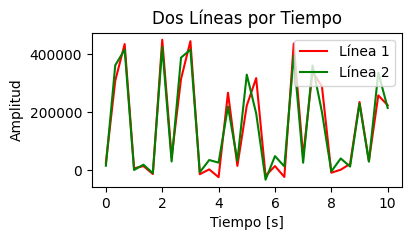

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Genera arrays de tiempo y valores para las dos líneas
t = np.linspace(0, 10, 31)  # Tiempo desde 0 a 10 segundos con 100 puntos

y1 = y_atm_test
y2 = y_pred

# Crea la figura y el eje
plt.figure(figsize=(4,2))
ax = plt.subplot(111)

# Plotea las dos líneas de tiempo
ax.plot(t, y1, label='Línea 1', color='red')
ax.plot(t, y2, label='Línea 2', color='green')

# Personaliza la gráfica
ax.set_title('Dos Líneas por Tiempo')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud')
ax.legend(loc='upper right')  # Localiza la leyenda en la esquina superior derecha

# Muestra la gráfica
plt.show()

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def el_bandido():
    for i in range(1, 700 + 1):
        atm_data = aggregated_data[aggregated_data['codigo_cajero'] == i]
        atm_data = atm_data.sort_values(by=['fecha_transaccion'])
        atm_data = atm_data.drop(columns=['codigo_cajero', 'Type'])
        categorical_features_list = ['tipo_cajero', 'Weekday', 'Holiday Sequence']
        atm_data = pd.get_dummies(atm_data, columns=categorical_features_list, drop_first=True)

        # crear una columna "demanda_real" sin desplazar (para referencia)
        # atm_data['demanda_real'] = atm_data['demanda']
        # crear una columna "demanda_shifted" con un shift de 7 días
        atm_data['demanda_shifted'] = atm_data['demanda'].shift(7)
        atm_data = atm_data[atm_data['demanda_shifted'].notna()]
        atm_data = atm_data.drop(columns=["demanda"], axis=1)



        for obs in range(1,6):
            atm_data["demanda_shifted_" + str(obs)] = atm_data['demanda_shifted'].shift(obs, fill_value=0)

        atm_data['fecha_transaccion'] = pd.to_datetime(atm_data['fecha_transaccion'])

        atm_data_train = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2023-06-02")) & \
                                    (atm_data['fecha_transaccion'] < pd.to_datetime("2024-02-10"))]

        atm_data_val = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2024-02-10")) & \
                                        (atm_data['fecha_transaccion'] < pd.to_datetime("2024-03-14"))]
                                        
        atm_data_test = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2024-03-14")) & \
                                        (atm_data['fecha_transaccion'] < pd.to_datetime("2024-04-14"))]

        clean_atm_train = atm_data_train.drop(columns=["fecha_transaccion"], axis=1)
        clean_atm_val = atm_data_val.drop(columns=["fecha_transaccion"], axis=1)
        clean_atm_test = atm_data_test.drop(columns=["fecha_transaccion"], axis=1)

        X_atm_train, y_atm_train = clean_atm_train.drop(["demanda_shifted"],axis=1), clean_atm_train['demanda_shifted']
        X_atm_val, y_atm_val = clean_atm_val.drop(["demanda_shifted"],axis=1), clean_atm_val['demanda_shifted']
        X_atm_test, y_atm_test = clean_atm_test.drop(["demanda_shifted"],axis=1), clean_atm_test['demanda_shifted']

        rfr = RandomForestRegressor(random_state=2024,verbose=0,n_jobs=5)
        rfr.fit(X_atm_train, y_atm_train)

        y_pred = rfr.predict(X_atm_test)

        # Calcular MAPE, MAE, MSE y RMSE
        r2 = r2_score(y_atm_test, y_pred)
        mape = mean_absolute_percentage_error(y_atm_test, y_pred)
        mae = mean_absolute_error(y_atm_test, y_pred)
        mse = mean_squared_error(y_atm_test, y_pred)
        rmse = np.sqrt(mse)

        # print(y_pred)
        # Mostrar los resultados
        print(f'ATM {i:3d} => TEST => R2: {r2:.2f} MAPE: {mape:.2f}% MAE: {mae:.2f} MSE: {mse:.2f} RMSE: {rmse:.2f}')
        if(i % 1 == 0):
            break

el_bandido()

ATM   1 => TEST => R2: 0.93 MAPE: 606809202695607168.00% MAE: 33111.93 MSE: 2219630881.17 RMSE: 47112.96


In [27]:
atm_data = aggregated_data[aggregated_data['codigo_cajero'] == 1]
atm_data = atm_data.sort_values(by=['fecha_transaccion'])
atm_data = atm_data.drop(columns=['codigo_cajero', 'Type'])
categorical_features_list = ['tipo_cajero', 'Weekday', 'Holiday Sequence']
atm_data = pd.get_dummies(atm_data, columns=categorical_features_list, drop_first=True)

# crear una columna "demanda_real" sin desplazar (para referencia)
# atm_data['demanda_real'] = atm_data['demanda']
# crear una columna "demanda_shifted" con un shift de 7 días
atm_data['demanda_shifted'] = atm_data['demanda'].shift(7)
atm_data = atm_data[atm_data['demanda_shifted'].notna()]
atm_data = atm_data.drop(columns=["demanda"], axis=1)


for obs in range(1,6):
    atm_data["demanda_shifted_" + str(obs)] = atm_data['demanda_shifted'].shift(obs, fill_value=0)

atm_data['fecha_transaccion'] = pd.to_datetime(atm_data['fecha_transaccion'])

atm_data_train = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2023-06-02")) & \
                            (atm_data['fecha_transaccion'] < pd.to_datetime("2024-02-10"))]

atm_data_val = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2024-02-10")) & \
                                (atm_data['fecha_transaccion'] < pd.to_datetime("2024-03-14"))]
                                
atm_data_test = atm_data.loc[(atm_data['fecha_transaccion'] >= pd.to_datetime("2024-03-14")) & \
                                (atm_data['fecha_transaccion'] < pd.to_datetime("2024-04-14"))]

clean_atm_train = atm_data_train.drop(columns=["fecha_transaccion"], axis=1)
clean_atm_val = atm_data_val.drop(columns=["fecha_transaccion"], axis=1)
clean_atm_test = atm_data_test.drop(columns=["fecha_transaccion"], axis=1)


X_atm_train, y_atm_train = clean_atm_train.drop(["demanda_shifted"],axis=1), clean_atm_train['demanda_shifted']
X_atm_val, y_atm_val = clean_atm_val.drop(["demanda_shifted"],axis=1), clean_atm_val['demanda_shifted']
X_atm_test, y_atm_test = clean_atm_test.drop(["demanda_shifted"],axis=1), clean_atm_test['demanda_shifted']

# print(X_atm_train.columns)

rfr = RandomForestRegressor(random_state=2024,verbose=0,n_jobs=5)
rfr.fit(X_atm_train, y_atm_train)

y_pred = rfr.predict(X_atm_test)

# Calcular MAPE, MAE, MSE y RMSE
r2 = r2_score(y_atm_test, y_pred)
mape = mean_absolute_percentage_error(y_atm_test, y_pred)
mae = mean_absolute_error(y_atm_test, y_pred)
mse = mean_squared_error(y_atm_test, y_pred)
rmse = np.sqrt(mse)

# print(y_pred)
# Mostrar los resultados
print(f'ATM {1:3d} => TEST => R2: {r2:.2f} MAPE: {mape:.2f}% MAE: {mae:.2f} MSE: {mse:.2f} RMSE: {rmse:.2f}')


Index(['saldo_inicial', 'abastecimiento', 'saldo_final', 'isYesterdayHoliday',
       'isHoliday', 'isTomorrowHoliday', 'isYesterdayWeekday',
       'isTomorrowWeekday', 'isWeekday', 'isPaymentDay', 'isPayweek',
       'rolling_mean_weekday', 'rolling_max', 'lag_6', 'rolling_max_weekday',
       'rolling_std', 'rolling_mean', 'Weekday_MONDAY', 'Weekday_SATURDAY',
       'Weekday_SUNDAY', 'Weekday_THURSDAY', 'Weekday_TUESDAY',
       'Weekday_WEDNESDAY', 'Holiday Sequence_HHW', 'Holiday Sequence_HWH',
       'Holiday Sequence_HWW', 'Holiday Sequence_WHH', 'Holiday Sequence_WHW',
       'Holiday Sequence_WWH', 'Holiday Sequence_WWW', 'demanda_shifted_1',
       'demanda_shifted_2', 'demanda_shifted_3', 'demanda_shifted_4',
       'demanda_shifted_5'],
      dtype='object')
Características más importantes:
rolling_mean_weekday: 0.86
rolling_max_weekday: 0.09
demanda_shifted_4: 0.01
saldo_inicial: 0.01
saldo_final: 0.00
demanda_shifted_1: 0.00
lag_6: 0.00
demanda_shifted_3: 0.00
demanda_sh

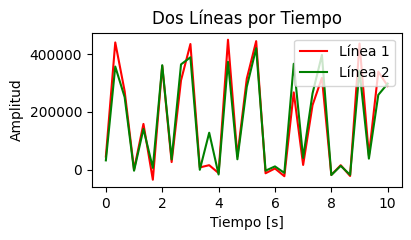

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Genera arrays de tiempo y valores para las dos líneas
t = np.linspace(0, 10, 31)  # Tiempo desde 0 a 10 segundos con 100 puntos

y1 = y_atm_test
y2 = y_pred

# Crea la figura y el eje
plt.figure(figsize=(4,2))
ax = plt.subplot(111)

# Plotea las dos líneas de tiempo
ax.plot(t, y1, label='Línea 1', color='red')
ax.plot(t, y2, label='Línea 2', color='green')

# Personaliza la gráfica
ax.set_title('Dos Líneas por Tiempo')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud')
ax.legend(loc='upper right')  # Localiza la leyenda en la esquina superior derecha

# Muestra la gráfica
plt.show()

In [107]:
X_train,y_train = clean_train.drop(["demanda"],axis=1), clean_train['demanda']
X_test,y_test = clean_test.drop(["demanda"],axis=1), clean_test['demanda']
X_val,y_val = clean_val.drop(["demanda"],axis=1), clean_val['demanda']

In [108]:
rfr = RandomForestRegressor(random_state=2024,verbose=0,n_jobs=5)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_jobs=5, random_state=2024)

In [113]:
root_mean_squared_error(y_train, rfr.predict(X_train))

20293.417749747594

In [117]:
# atm_1_test['demanda_RFR'] = rfr.predict(X_test)

print("Root Mean Squared Errors")
print(f'Train R2 Score => {rfr.score(X_train, y_train)}, RMSE => {root_mean_squared_error(y_train, rfr.predict(X_train))}')
print(f'Val R2 Score => {rfr.score(X_val, y_val)}, RMSE => {root_mean_squared_error(y_val, rfr.predict(X_val))}')
print(f'Test R2 Score => {rfr.score(X_test, y_test)}, RMSE => {root_mean_squared_error(y_test, rfr.predict(X_test))}')

Root Mean Squared Errors
Train R2 Score => 0.9875786610879072, RMSE => 20293.417749747594
Val R2 Score => 0.934334443030072, RMSE => 42922.73122299906
Test R2 Score => 0.9268897565755475, RMSE => 45231.10359792752


In [96]:
# Calcular el ranking de características más importantes
importancias_caracteristicas = rfr.feature_importances_

# Ordenar las importancias en orden descendente
importancias_ordenadas = np.argsort(importancias_caracteristicas)[::-1]

# Mostrar las 10 características más importantes (por ejemplo)
print("Características más importantes:")
for i in range(10):
    caracteristica = X_train.columns[importancias_ordenadas[i]]
    importancia = importancias_caracteristicas[importancias_ordenadas[i]]
    print(f"{caracteristica}: {importancia:.2f}")

Características más importantes:
rolling_mean_weekday: 0.47
rolling_max_weekday: 0.37
saldo_inicial: 0.08
rolling_max: 0.01
demanda_1: 0.01
demanda_2: 0.01
rolling_std: 0.01
demanda_5: 0.01
saldo_final: 0.01
demanda_4: 0.01


# XGBoost

In [6]:
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [37]:
atm_1_train.columns

Index(['fecha_transaccion', 'saldo_inicial', 'demanda', 'abastecimiento',
       'saldo_final', 'isYesterdayHoliday', 'isHoliday', 'isTomorrowHoliday',
       'isYesterdayWeekday', 'isTomorrowWeekday', 'isWeekday', 'isPaymentDay',
       'isPayweek', 'rolling_mean_weekday', 'rolling_max', 'lag_6',
       'rolling_max_weekday', 'rolling_std', 'rolling_mean', 'Weekday_MONDAY',
       'Weekday_SATURDAY', 'Weekday_SUNDAY', 'Weekday_THURSDAY',
       'Weekday_TUESDAY', 'Weekday_WEDNESDAY', 'Holiday Sequence_HHW',
       'Holiday Sequence_HWH', 'Holiday Sequence_HWW', 'Holiday Sequence_WHH',
       'Holiday Sequence_WHW', 'Holiday Sequence_WWH', 'Holiday Sequence_WWW',
       'demanda_1', 'demanda_2', 'demanda_3', 'demanda_4', 'demanda_5'],
      dtype='object')

In [85]:
temp = atm_1
temp['fecha_transaccion'] = pd.to_datetime(temp['fecha_transaccion'])
temp = temp.set_index('fecha_transaccion')
temp = temp.sort_index()

fin_train = '2024-02-10 00:00:00'
inicio_validacion = '2024-02-11 00:00:00'
fin_validacion = '2024-03-13 23:59:00'

datos_train = temp.loc[: fin_train, :]
datos_val = temp.loc[inicio_validacion:fin_validacion, :]
datos_test = temp.loc[fin_validacion:, :]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()} (n={len(datos_train)})")
print(f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()} (n={len(datos_val)})")
print(f"Fechas test : {datos_test.index.min()} --- {datos_test.index.max()} (n={len(datos_test)})")

Fechas train : 2023-06-02 00:00:00 --- 2024-02-10 00:00:00 (n=254)
Fechas validación : 2024-02-11 00:00:00 --- 2024-03-13 00:00:00 (n=32)
Fechas test : 2024-03-14 00:00:00 --- 2024-04-14 00:00:00 (n=32)


In [86]:
min_date = atm_1['fecha_transaccion'].min()
max_date = atm_1['fecha_transaccion'].max()
print(min_date)
print(max_date)
print(pd.to_datetime(atm_1['fecha_transaccion'].max()) - pd.to_datetime(atm_1['fecha_transaccion'].min()))
difference = 317
# 8:1:1
# aggregated_data['Transaction Date'] = aggregated_data['Transaction Date'] + pd.DateOffset(years=7)
print(difference * 0.8)
print(difference * 0.1)
print(difference * 0.1)

print(pd.to_datetime(min_date) + pd.DateOffset(days=int(difference * 0.8)))
print(pd.to_datetime(max_date) - pd.DateOffset(days=int(difference * 0.1)))

2023-06-02 00:00:00
2024-04-14 00:00:00
317 days 00:00:00
253.60000000000002
31.700000000000003
31.700000000000003
2024-02-10 00:00:00
2024-03-14 00:00:00


In [87]:
forecaster = ForecasterAutoreg(
 regressor = XGBRegressor(random_state=123, n_jobs=-1),
#  lags = 24
 lags = 2
#  lags = 6
 )
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [1 2] 
Transformer for y: None 
Transformer for exog: None 
Window size: 2 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: None 

In [ ]:
# Grid search de hiperparámetros y lags
# ==========================================================================
# Hiperparámetros del regresor
from skforecast.model_selection import grid_search_forecaster

param_grid = {
 'n_estimators': [100, 500],
 'max_depth': [3, 5, 10],
 'learning_rate': [0.01, 0.1]
}
# Lags utilizados como predictores
lags_grid = [2, 8]
# lags_grid = [48, 72]
resultados_grid = grid_search_forecaster(
 forecaster = forecaster,
 y = temp.loc[:fin_validacion, 'demanda'], # datos.loc[:fin_validacion, 'users'], # datos entrenamiento y validación
 param_grid = param_grid,
 lags_grid = lags_grid,
#  steps = 36,
 steps = 2,
 refit = False,
 metric = 'mean_squared_error',
 initial_train_size = len(datos_train), # El modelo se entrena con los datos de entrenamiento
 return_best = True,
 n_jobs = 'auto',
 verbose = False
)


# LSTM

In [105]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM